<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/keras_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras APIs
With Keras a model can be built as a

* sequence of layers
* graph of layers
* from scratch

Every model has a mathematical representation based on matrix multiplication and matrix functions. We can use the data structure and functions provided by Keras to create sequential or graph-like models. We can also subclass the Keras components to create new ones but in this case we will not be able to use most of the Keras APIs.

In [57]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## Sequential model

In [46]:
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))

### Model initialization and number of layer's parameters
In order to build a model we have to provide the batch size and the size (shape) of the examples that will be used as input. If we are dealing with images the dimensions are: height, width, and channels. The input tensor will be: (Batch size, Height, Width, Channels). The number of parameters to be trained depend on the input shape and the number of units to which we have to add the bias. For instance: if the input shape S is 3 (three numerical values),the number of units U is 64, and each unit has a bias B, the number of parameters P of the layer will be

P = S * U + B

For our example of inputs of shape 3, a layer with 64 units each with a bias we have

P = 3 * 64 + 64 = 256

In order to initialize a model, i.e. initialize the weights of the network, the batch size is not needed, what is needed is the size of input and that of the network (number of units per layer).

In [48]:
batch_size = None
model.build(input_shape=(batch_size, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                256       
                                                                 
 my_last_layer (Dense)       (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Functional models
Beyond the sequential model we can build non-sequential models like directed acyclic graphs (DAG) by linking layers. We can see the previous sequential model built using the functional APIs that will allow us to create more complex networks.

In [51]:
input_shape = 3
inputs = keras.Input(shape=(input_shape,), name="my_input")
features = layers.Dense(64, activation="relu", name="features")(inputs)
outputs = layers.Dense(10, activation="softmax", name="outputs")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [52]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 features (Dense)            (None, 64)                256       
                                                                 
 outputs (Dense)             (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Multi-input, multi-output models
As a simple example of a non-sequential model, We build a network with three different inputs, and two outputs.

In [53]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

In [54]:
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)


In [55]:
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

In [56]:
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

We can use synthetic data for the input

In [59]:
num_samples = 1280
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

and for the output (target)

In [60]:
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

In [61]:
model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"], metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1)
model.evaluate([title_data, text_body_data, tags_data], [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 7ms/step


We can plot the network topology

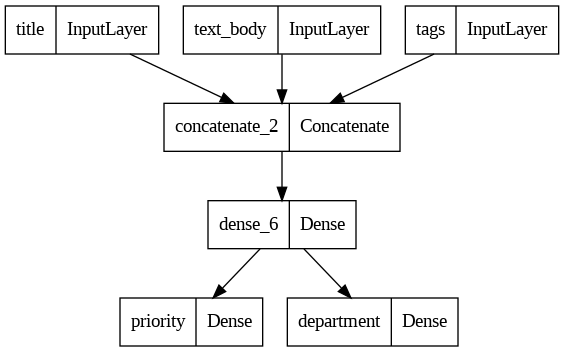

In [62]:
keras.utils.plot_model(model, "ticket_classifier.png")

## Model subclassing
We can build models by subclassing the Keras data structures

In [63]:
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
            num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [66]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
           [priority_data, department_data],
           epochs=1)

model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
                [priority_data, department_data])

priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

40/40 [==============================] - 0s 8ms/step
